In [31]:
### Prepare module structure ###

import sys
sys.path.append('../')

In [32]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
from data import *
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0.0


In [33]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


fashion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


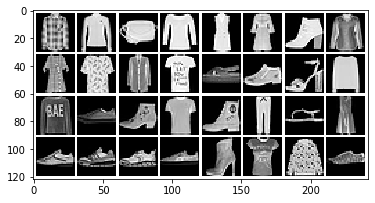

torch.Size([32, 1, 28, 28])


In [4]:
### LOAD DATA ###
dataset = 'fashion'
dataloader, imsize = load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
plot_grid(sample)
print(sample.shape)
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft**2, -1))

In [5]:
def poisson_noise(magn, device, alpha=1):
    intens = magn ** 2
    alpha_2 = alpha ** 2
    lmd = intens / alpha_2
    intens_noise = alpha_2 * torch.distributions.poisson.Poisson(lmd).sample()
    magn_noise = torch.sqrt(intens_noise)
    return magn_noise

def calc_mags(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    return mags

# Function to compute test images
def test_generator(model, device, testloader, alpha):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        z = torch.randn(*data.shape).to(device)
        data = data.to(device=device)
        magn = poisson_noise(calc_mags(data), device, alpha)
        net_input = torch.cat([z, magn], dim=1)
        ouput = model(net_input)

        test_images.append(data.cpu().numpy())
        outputs.append(ouput.cpu().detach().numpy())
    
    return np.concatenate(outputs), np.concatenate(test_images)

In [8]:
### LOAD MODEL ###

latent_dim = 128
hidden_dim = 500

vae = models.SignalVAE(shape=imsize, latent_dim=latent_dim, hidden_dim=hidden_dim)
vae.load_state_dict(torch.load("../cache/models/VAE_Fashion/FC-VAE128Fashion_3.sd"));

Version 4


In [7]:
### Hand Paper (adapted) ###
def vaeopt(sample_magnitudes, vae, device, measurement_fn=calc_mags,
           z_shape=(20, 1, 1), init_x=None, optim_lr=1e-1, max_steps=5000, max_loss=0.0):
    
    vae.to(device)
    vae.eval()
    
    N = sample_magnitudes.shape[0]
    
    if init_x is None:
        z = torch.randn((N, *z_shape), requires_grad=True, device=device)
    else:
        z = vae.encoder(init_x)[0].clone().detach().requires_grad_(True)
        
    optimizer = optim.Adam([z], lr=optim_lr)
    
    losses = []
    last_out = vae.decoder(z)
    
    for i in range(max_steps):
 
        magnitudes = measurement_fn(last_out)
        mse_all = torch.mean((magnitudes - sample_magnitudes) ** 2, dim=tuple(np.arange(len(magnitudes.shape))[1:]))
        loss = torch.sum(mse_all)
        
        if loss < max_loss:
            break
   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        last_out = vae.decoder(z)

        losses.append(loss.detach().cpu().item())
        
    return last_out.detach(), losses, mse_all

In [95]:
### Test one sample Fourier magnitudes random init + multiple restarts ###

alphas = [0.1]

for alpha in alphas:

    num_batches = 32
    batch_size = 32
    max_steps = 10000
    max_loss = 0.0
    optim_lr = 1e-1
    restarts = 3

    ###

    out_original = np.zeros((batch_size * num_batches, *imsize))
    out_results = np.zeros((batch_size * num_batches, *imsize))
    mse_all = np.full((batch_size * num_batches), np.inf)

    for batch_i, batch in enumerate(dataloader['test']):
        test_sample = batch.to(device)
        test_magnitudes = poisson_noise(calc_mags(test_sample), device, alpha)  
        out_original[batch_size * batch_i : batch_size * batch_i + batch_size] = test_sample.cpu().numpy()

        for r in range(restarts):
            cur_out_results, cur_loss, cur_mse_all = vaeopt(sample_magnitudes=test_magnitudes, vae=vae, device=device,
                                                            z_shape=(latent_dim, ), optim_lr=optim_lr, max_steps=max_steps,
                                                            max_loss=max_loss)
            cur_out_results = cur_out_results.cpu().numpy()

            for i in range(batch_size):
                mse = mse_all[batch_size * batch_i + i]
                if cur_mse_all[i] < mse:
                    out_results[batch_size * batch_i + i] = cur_out_results[i]
                    mse_all[batch_size * batch_i + i] = cur_mse_all[i]

        print("Batch {0}/{1} finished".format(batch_i + 1, num_batches))
        if batch_i + 1 >= num_batches:
            break

    plt.semilogy(cur_loss)
    plt.show()
    
    
    ### CACHE RESULTS ###

    #import pickle
    #pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_Fashion/randomInit_original_1024_alpha{}.p".format(alpha), "wb"))
    #pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_Fashion/randomInit_1024_alpha{}.p".format(alpha), "wb"))

Batch 1/32 finished
Batch 2/32 finished
Batch 3/32 finished


KeyboardInterrupt: 

In [ ]:
### CACHE RESULTS ###

#alpha = 0.1

import pickle
pickle.dump(out_original, open("/home/shared/phase-retrieval/test/VAE_Fashion/randomInit_original_1024_alpha{}.p".format(alpha), "wb"))
pickle.dump(out_results, open("/home/shared/phase-retrieval/test/VAE_Fashion/randomInit_1024_alpha{}.p".format(alpha), "wb"))

In [92]:
### LOAD RESULTS ###
import pickle

alpha = 3.0

out_original = pickle.load(open("/home/shared/phase-retrieval/test/VAE_Fashion/randomInit_original_1024_alpha{}.p".format(alpha), "rb"))
out_results = pickle.load(open("/home/shared/phase-retrieval/test/VAE_Fashion/randomInit_1024_alpha{}.p".format(alpha), "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Output under minimized magnitude distance:


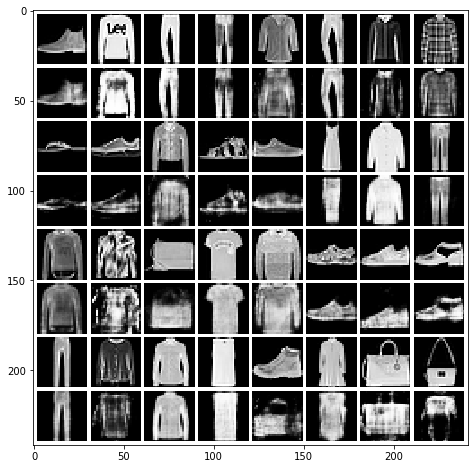

Registered:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


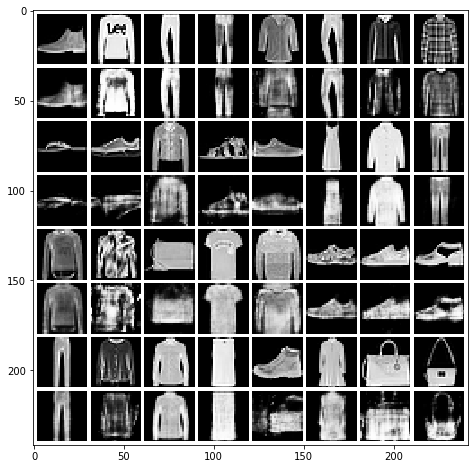

In [93]:
# Benchmark results

print("Output under minimized magnitude distance:")

to_plot = np.stack([out_original[:32].reshape(4, 8, 28, 28), 
                    out_results[:32].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)         
plot_grid(to_plot, figsize=(8, 8),
          file="../out/vae/fashion/{0}{1}.png".format('randomInit_1024_alpha{}_'.format(alpha), time.strftime("%Y%m%d_%H%M%S")))

print("Registered:")
results_reg = register_croco(out_results[:32], out_original[:32])
to_plot = np.stack([out_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8),
          file="../out/vae/fashion/{0}{1}.png".format('randomInit_1024_alpha{}_reg'.format(alpha), time.strftime("%Y%m%d_%H%M%S")))

In [94]:
benchmark(pred=out_results, true=out_original, check_all=True)

Signal error:
  MSE: 0.05696334155866137, std: 0.05248167849435733
  MAE: 0.12305914202193671, std: 0.07397388688060608
  SSIM: 0.4980330051648835, std: 0.2781769003111516
  Sharpness: 0.13407673838519285, std: 0.06458588281826814
  PhCo-MSE: 0.041831521482692445, std: 0.058181101926431236
  PhCo-MAE: 0.10429160274859958, std: 0.08573867456963662
  PhCo-SSIM: 0.6079720834888588, std: 0.2728990841913259
  CroCo-MSE: 0.025194827498040577, std: 0.023447016661526543
  CroCo-MAE: 0.08176464280264494, std: 0.046434974555216446
  CroCo-SSIM: 0.6746074822929229, std: 0.20275732720282086

Magnitude error:
  MSE Magnitude: 1.8902703600553923, std: 1.2762007793644106

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 1.00] - should be in [0, 1]

Markdown table values:
 0.05696 | 0.1231 | 0.4980 | 0.1341 | 0.04183 | 0.1043 | 0.6080 | 0.02519 | 0.08176 | 0.6746 | 1.890 |


## Test Fourier magnitudes random init (1024 samples)

| Nr | alpha | MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 | 0.1 | 0.05984 | 0.1261 | 0.4838 | 0.1409 | 0.04471 | 0.1078 | 0.5954 | 0.02736 | 0.08461 | 0.6619 | 1.576 |
| 3 | 0.3 | 0.06319 | 0.1303 | 0.4783 | 0.1424 | 0.04613 | 0.1099 | 0.5917 | 0.02809 | 0.08597 | 0.6560 | 1.580 |
| 3 | 1.0 | 0.06174 | 0.1284 | 0.4785 | 0.1399 | 0.04412 | 0.1074 | 0.5967 | 0.02725 | 0.08461 | 0.6589 | 1.620 |
| 3 | 3.0 | 0.05696 | 0.1231 | 0.4980 | 0.1341 | 0.04183 | 0.1043 | 0.6080 | 0.02519 | 0.08176 | 0.6746 | 1.890 |
| 3 | 10.0 | 0.05621 | 0.1302 | 0.4571 | 0.1427 | 0.04695 | 0.1201 | 0.5371 | 0.02714 | 0.09200 | 0.6206 | 4.437 |
| 3 | 25.0 | 0.06219 | 0.1498 | 0.3729 | 0.1582 | 0.08028 | 0.1758 | 0.3626 | 0.03564 | 0.1147 | 0.5149 | 10.27 |
| 3 | 50.0 | 0.06616 | 0.1642 | 0.3223 | 0.1661 | 0.1081 | 0.2195 | 0.2592 | 0.04517 | 0.1366 | 0.4322 | 17.90 |